# 第六课 数字冰壶比赛中DQN算法的实现

## 6.1 DQN算法简介

### 6.1.1 Q-learning算法

状态-动作价值函数（State-Action Value Function）又被称为质量函数（Quality Function）或Q函数，是强化学习的核心概念之一。

5.2.3节中讲到了状态-动作价值函数$Q(s,a)$的意义，它表示在某一具体信息状态$s$和动作$a$的情况下，对未来收益的期望值。Q-Learning算法会生成一个Q-table，该表中记录了不同状态$s(s∈S)$下采取不同动作$a(a∈A)$时所获得的Q值。

|Q-table|$a1$|$a2$|$a3$|…|
|:---:|:---:|:---:|:---:|:---:|
|$s_1$|$Q(s_1,a_1)$|$Q(s_1,a2)$|$Q(s_1,a_3)$||
|$s_2$|$Q(s_2,a_1)$|$Q(s_2,a_2)$|$Q(s_2,a_3)$||
|$s_3$|$Q(s_3,a_1)$|$Q(s_3,a_2)$|$Q(s_3,a_3)$||
|…||||

探索环境之前，初始化Q-table，当智能体与环境交互的过程中，算法利用贝尔曼方程来迭代更新$Q(S,a)$，每一轮结束后就生成了一个新的Q-table。智能体不断与环境进行交互，不断更新这个表格，使其最终能收敛。最终，智能体就能通过表格判断在某个状态s下采取什么动作，才能获得最大的Q值。

具体更新方法如下式所示：

$$Q(s_t,a_t)←Q(s_t,a_t)+α[r_{t+1}+γ\max \limits_aQ(s_{t+1},a_t)-Q(s_t,a_t)]\tag{6-1}$$

其中$Q(s_t,a_t)$是在状态$s_t$下采取动作$a_t$的长期回报，是一个估计Q值；$r_{t+1}$是在状态$s_t$下执行动作$a_t$得到的奖励（Reward）；$\max_aQ(s_{t+1},a_t)$指的是在状态$s_{t+1}$下所获得的最大Q值，直接看Q-table取它最大化的值；$γ$是折扣因子，含义是看重近期收益，弱化远期收益，同时也保证Q函数收敛。$r_{t+1}+γ\max\limits_aQ(s_{t+1},a_t)-Q(s_t,a_t)$即为目标值，就是时序差分目标，是$Q(s_t,a_t)$想要逼近的目标。$α$是学习率，衡量更新的幅度。

当目标值和估计值的差值趋于0的时候，$Q(s,a)$就不再继续变化，Q表趋于稳定，说明得到了一个收敛的结果。这就是算法想要达到的效果。

这里需要注意，$\max_a Q(s_{t+1},a_t)$所对应的动作不一定是下一步会执行的实际动作。这里涉及到一个叫做ε−greedy的算法，即ε−贪心算法。在智能体探索过程中，执行的动作采用ε−greedy策略，是权衡探索（exploration）和利用（exploitation）的超参数。

- exploration：探索环境，通过尝试不同的动作来得到可以带来最大奖励的最佳策略
- exploitation：不去尝试新的动作，利用已知的可以带来很大奖励的动作，Q-Learning算法中就是根据Q-table选择当前状态下能使Q值最大的动作。

做exploitation和exploration的目的是获得一种长期收益最高的策略，这个过程可能对短期奖励有损失。如果exploitation太多，那么模型比较容易陷入局部最优，但是exploration太多，模型收敛速度太慢。这就是exploitation-exploration权衡。

比如我们设ε=0.9，随机化一个[0,1]的值，如果它小于ε，则进行exploration，随机选择动作；如果它大于ε，则进行exploitation，选择Q value最大的动作。在训练过程中，ε在刚开始的时候会被设得比较大，让智能体充分探索，然后ε逐步减少，智能体会开始慢慢选择Q value最大的动作。

### 6.1.2 DQN算法中神经网络的训练

Q-learning算法中才用的Q-table存在很大的局限性。在现实中很多情况下，强化学习任务所面临的状态空间是连续的，存在无穷多个状态，这种情况就不能再使用表格的方式存储价值函数。

为了解决这个问题，我们可以用一个函数Q(s,a;w)来近似动作-价值Q(s,a)，称为价值函数近似（Value Function Approximation），我们用神经网络来生成这个函数Q(s,a;w)，称为Q网络（Deep Q-network），其中w是神经网络训练的参数。

通俗来讲，就是将状态和动作当成神经网络的输入，然后经过神经网络分析后得到动作的Q值，这样我们就没必要在表格中记录Q值，而是直接使用神经网络生成Q值。还有一种形式是只输入状态值，输出所有的动作值，然后按照Q-learning的原则，直接选择拥有最大值的动作当做下一步要做的动作。

神经网络的训练是一个最优化问题，我们需要表示网络输出和标签值之间的差值，作为损失函数，目标是让损失函数最小化，手段是通过反向传播使用梯度下降的方法来更新神经网络的参数。

DQN算法中神经网络训练的具体过程如下：

1. 初始化网络，输入状态$s_t$，输出$s_t$下所有动作的Q值；
2. 利用策略(例如ε−greddy)，选择一个动作$a_t$，把$a_t$输入到环境中，获得新状态$s_{t+1}$和奖励r；
3. 计算TD target：$y_t=r_t + γ\max\limits_aQ(s_{t+1},a;w)$
4. 计算损失函数: $L=1/2[y_t - Q(s,a;w)]^2$
5. 更新Q参数，使得$Q(s_t,a_t)$尽可能接近$y_t$，可以把它当做回归问题，利用梯度下降做更新工作；
6. 从以上步骤我们得到一个四元组transition:$(s_t,a_t,r_t,s_{t+1})$，用完之后丢弃掉；
7. 输入新的状态，重复更新工作

基础DQN算法网络训练流程图如下图所示：

<center><img src="img/DQN_update.png" width=600></center>

### 6.1.3 经验回放（Experience replay）

在理解经验回放之前，先看看原始DQN算法的缺点：
1. 用完一个transition:$(s_t,a_t,r_t,s_{t+1})$就丢弃，会造成对经验的浪费；
2. 按顺序使用transition，使得前一个transition和后一个transition相关性很强，这种相关性对学习Q网络是有害的。

经验回放可以克服上面两个缺点：
1. 把序列打散，消除相关性，使得数据满足独立同分布，从而减小参数更新的方差，提高收敛速度。
2. 能够重复使用经验，数据利用率高，对于数据获取困难的情况尤其有用。

在进行强化学习的时候，往往最花时间的步骤是与环境交互，训练网络反而是比较快的，因为我们用GPU训练很快。用回放缓冲区可以减少与环境交互的次数，经验不需要统统来自某一个策略，一些由过去的策略所得到的经验可以再回放缓冲区被使用多次，反复地再利用。

经验回放会构建一个回放缓冲区（replay buffer），存储n条transition，称为经验。某一个策略π与环境交互，收集很多条transition，放入回放缓冲区，回放缓冲区中的经验transition可能来自不同的策略。回放缓冲区只有在它装满的时候才会吧旧的数据丢掉。每次随机抽出一个batch大小的transition数据训练网络，算出多个随机梯度，用梯度的平均更新Q网络参数w。

### 6.1.4 目标网络（Target Network）

我们在训练网络的时候，动作价值估计和权重w有关。当权重变化时，动作价值的估计也会发生变化。在学习的过程中，动作价值试图追逐一个变化的回报，容易出现不稳定的情况。

解决办法就是引入第二个网络$Q(s,a;w^-)$，称为目标网络。原来的网络$Q(s,a;w)$称为评估网络。这两个网络的结构一样，只是参数不同，$w^−≠w$。

两个网络的作用也不一样：评估网络$Q(s,a;w)$负责控制智能体，收集经验；目标网络$Q(s,a;w^-)$用于计算TD target：$y_t=r_t + γ\max\limits_aQ(s_{t+1},a;w^-)$。在更新过程中，只更新评估网络$Q(s,a;w)$的权重w，目标网络$Q(s_{t+1},a;w^-)$的权重$w^-$保持不变。

在更新一定次数后，再将更新过的评估网络的权重复制给目标网络，进行下一批更新，这样目标网络也能得到更新。由于在目标网络没有变化的一段时间内回报的目标值是相对固定的，因此目标网络的引入增加了学习的稳定性。

还有进一步的改进算法，称为Double Q。该算法用原始网络$Q(s,a;w)$，选出使Q值最大化的那个动作，记为$a^∗$。再在目标网络中使用这个$a^∗$计算TD target：$y_t=r_t + γ\max\limits_aQ(s_{t+1},a^*;w^-)$。

引入了经验回放和目标网络的DQN算法流程图如下图所示：

<center><img src="img/DQN_process.png" width=600></center>

### 6.1.5 DQN算法伪代码

<img src="img/DQN_code.png">

其中，第1-3行实现了初始化，设定目标网络的权重$θ^-$与原来的训练网络的权重θ相同。第6-9行是经验回放部分，将每次从环境中采样得到的四元组数据存储到回放缓冲区。第10-12行从回放缓冲区中随机采样，并计算label和损失函数。第13行实现了目标网络，每N步将目标网络的参数与训练网络同步一次。

## 6.2 DQN算法在数字冰壶比赛中的实现

### 6.2.1 网络搭建

#### >> 导入算法实现所需要的模块

In [1]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

#### >> 网络输入设置

如前所述，根据场上的冰壶与营垒圆心的距离由近至远进行排序，每个冰壶包含五个信息：x坐标、y坐标、离营垒圆心的距离、投掷顺序、是否为有效得分壶，共80个特征作为网络输入。

> 这种描述方式仅供参考，对于环境的描述是强化学习的重要环节，不同的环境描述会影响到算法训练模型的效率与性能。

In [2]:
#获取某一冰壶距离营垒圆心的距离
def get_dist(x, y):
    House_x = 2.375
    House_y = 4.88
    return math.sqrt((x-House_x)**2+(y-House_y)**2)

#根据冰壶比赛服务器发送来的场上冰壶位置坐标列表获取得分情况并生成信息状态数组
def get_infostate(position):
    House_R = 1.830
    Stone_R = 0.145

    init = np.empty([8], dtype=float)
    gote = np.empty([8], dtype=float)
    both = np.empty([16], dtype=float)
    #计算双方冰壶到营垒圆心的距离
    for i in range(8):
        init[i] = get_dist(position[4 * i], position[4 * i + 1])
        both[2*i] = init[i] 
        gote[i] = get_dist(position[4 * i + 2], position[4 * i + 3])
        both[2*i+1] = gote[i]
    #找到距离圆心较远一方距离圆心最近的壶
    if min(init) <= min(g ote):
        win = 0                     #先手得分
        d_std = min(gote)
    else:
        win = 1                     #后手得分
        d_std = min(init)
    
    infostate = []  #状态数组
    init_score = 0  #先手得分
    #16个冰壶依次处理
    for i in range(16):
        x = position[2 * i]         #x坐标
        y = position[2 * i + 1]     #y坐标
        dist = both[i]              #到营垒圆心的距离
        sn = i % 2 + 1              #投掷顺序
        if (dist < d_std) and (dist < (House_R+Stone_R)) and ((i%2) == win):
            valid = 1               #是有效得分壶
            #如果是先手得分
            if win == 0:
                init_score = init_score + 1
            #如果是后手得分
            else:
                init_score = init_score - 1
        else:
            valid = 0               #不是有效得分壶
        #仅添加有效壶
        if x!=0 or y!=0:
            infostate.append([x, y, dist, sn, valid])
    #按dist升序排列
    infostate = sorted(infostate, key=lambda x:x[2])
    
    #无效壶补0
    for i in range(16-len(infostate)):
        infostate.append([0,0,0,0,0])

    #返回先手得分和转为一维的状态数组
    return init_score, np.array(infostate).flatten()

#### >> 网络输出设置

DQN 算法是基于价值的强化学习算法，需要将动作离散化。数字冰壶比赛中的动作是AI选手投壶时给出的初速度v0（0≤v0≤6）、横向偏移h0（-2.23≤h0≤2.23）和初始角速度ω0（-3.14≤ω0≤3.14）。

投壶初始速度的取值范围是0-6，而实际上在得分区中没有壶的情况下，能够投出得分壶的初始速度范围大概在2.8-3.2之间，而初速度在2.4-2.8之间的壶大概率是停留在防守区。因此考虑将初始速度在(2.4,2.7)之间以0.1为步长进行离散、在(2.8,3.2)之间以0.05为步长进行离散用于执行保护战术，另外再给出4、5和6三个速度值用于执行击飞战术。

当投壶初始速度为3（球停在7区）时，能够投出得分壶的横向偏移范围大概在(-2,2)之间，因此考虑将初始速度在(-2,2)之间以十分之一为步长进行离散，而初始角速度则以值域的十分之一为步长进行离散。

如上所述，最终将投掷动作离散化为1600种不同的组合，作为网络输出。

In [3]:
#低速：在(2.4,2.7)之间以0.1为步长进行离散
slow = np.arange(2.4, 2.7, 0.1)
#中速：在(2.8,3.2)之间以0.05为步长进行离散
normal = np.arange(2.8, 3.2, 0.05)
#高速
fast = np.array([4,5,6])
#将低速、中速、高速三个数组连接起来
speed = np.concatenate((slow, normal, fast))

#横向偏移在(-2,2)之间以0.4为步长进行离散
deviation = np.arange(-2, 2, 0.4)
#角速度在(-3.14, 3.14)之间以0.628为步长进行离散
angspeed = np.arange(-3.14, 3.14, 0.628)

n = 0
#初始化动作列表
action_list = np.empty([1600, 3], dtype=float)
#遍历速度、横向偏移、角速度组合成各种动作
for i in speed:
    for j in deviation:
        for k in angspeed:
            action_list[n,] = [i, j, k]
            n += 1
print(n)

1600


#### >> 网络结构设置

搭建网络就要用到pytorch专门为神经网络设计的模块化接口torch.nn，该接口构建于autograd之上，可以用来定义和运行神经网络。

基于该接口定义自己的网络要用到nn.Module类，该类中包含网络各层的定义及forward方法。具体用法如下：

1. 需要继承nn.Module类，并实现forward方法。继承nn.Module类之后，在构造函数中要调用Module的构造函数, super().init()；
2. 一般把网络中具有可学习参数的层放在构造函数__init__()中，不具有可学习参数的层（如ReLU）可放在构造函数中，也可不放在构造函数中（在forward中使用nn.functional来代替）；
3. 只要在nn.Module中定义了forward函数，backward函数就会被自动实现（利用Autograd)。而且一般不是用net.forward()的方式显式调用forward, 而是用直接使用net(input)，就会自动执行forward()；
4. 在forward中可以使用任何Variable支持的函数，还可以使用if, for, print, log等python语法。

如下所示范例代码搭建了一个比较简单的三层神经网络，每一层都是线性层（全连接层），实现将80维的输入张量映射为256维张量再经Relu函数激活，继而映射为1024维张量，再经Relu函数激活，最终映射为1600维的输出张量。

In [4]:
class Net(nn.Module):
    #初始化网络
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(80, 256)         # 定义全连接层1
        self.fc1.weight.data.normal_(0, 0.1)  # 按(0, 0.1)的正态分布初始化权重
        self.fc2 = nn.Linear(256, 1024)       # 定义全连接层2
        self.fc2.weight.data.normal_(0, 0.1)  # 按(0, 0.1)的正态分布初始化权重
        self.out = nn.Linear(1024, 1600)      # 定义输出层
        self.out.weight.data.normal_(0, 0.1)  # 按(0, 0.1)的正态分布初始化权重
        
    #网络前向推理
    def forward(self, x):
        x = self.fc1(x)                       # 输入张量经全连接层1传递
        x = F.relu(x)                         # 经relu函数激活
        x = self.fc2(x)                       # 经全连接层2传递
        x = F.relu(x)                         # 经relu函数激活
        return self.out(x)                    # 经输出层传递得到输出张量

### 6.2.2 DQN模型搭建

#### >> 模型训练超参数设置

范例代码如下所示，需要注意的是代码中将EPSILON设置为固定值，在实际训练中建议对其进行动态设置，来达到前期重视探索，后期重视利用的目的。

In [5]:
BATCH_SIZE = 32            # 批次尺寸
LR = 0.0001                # 学习率
EPSILON = 0.7              # 最优选择动作百分比
GAMMA = 0.9                # 奖励折扣因子
TARGET_REPLACE_ITER = 500  # Q现实网络的更新频率
MEMORY_CAPACITY = 10000    # 记忆库大小

#### >> 模型搭建

In [6]:
class DQN(object):
    def __init__(self):
        self.eval_net = Net()                         # 初始化评价网络
        self.target_net = Net()                       # 初始化目标网络
        self.sum_loss = 0                             # 初始化loss值
        self.learn_step_counter = 0                   # 用于目标网络更新计时
        self.memory_counter = 0                       # 记忆库计数
        self.memory = np.zeros((MEMORY_CAPACITY, 80 * 2 + 2))  # 初始化记忆库
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)  # 设定torch的优化器为Adam
        self.loss_func = nn.MSELoss()                 # 以均方误差作为loss值
        self.min_loss = 10000

    #根据输入状态x返回输出动作的索引（而不是动作）
    def choose_action(self, x):
        # 选最优动作
        if np.random.uniform() < EPSILON:
            x = Variable(torch.FloatTensor(x))        # 将x转为pytorch变量 shape-torch.Size([80])
            actions_eval = self.eval_net(x)           # 评价网络前向推理 shape-torch.Size([1600])
            action = int(actions_eval.max(0)[1])      # 返回概率最大的动作索引
        # 选随机动作
        else:                                     
            action = np.random.randint(0, 1600)       # 在0-1600之间选一个随机整数
        return action                 

    #存储经验数据（s是输入状态，a是输出动作，r是奖励，s_是下一刻的状态）
    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, a, r, s_))         # 将输入元组的元素数组按水平方向进行叠加
        # 如果记忆库满了, 就覆盖老数据
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1

    #学习经验数据
    def learn(self):
        #每隔TARGET_REPLACE_ITER次更新目标网络参数
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        #抽取记忆库中的批数据
        size = min(self.memory_counter, MEMORY_CAPACITY)
        sample_index = np.random.choice(size, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]                 # 抽取出来的数据 shape-(32, 162)
        b_s = Variable(torch.FloatTensor(b_memory[:, :80]))     # 输入数据的状态 shape-torch.Size([32, 80])
        b_a = Variable(torch.LongTensor(b_memory[:, 80:81]))    # 输入数据的动作 shape-torch.Size([32, 1])
        b_r = Variable(torch.FloatTensor(b_memory[:, 81:82]))   # 输入数据的奖励 shape-torch.Size([32, 1])
        b_s_ = Variable(torch.FloatTensor(b_memory[:, -80:]))   # 输入数据的下一个状态 shape-torch.Size([32, 80])

        # 针对做过的动作 b_a 来选 q_eval 的值
        self.eval_net.train()                                   # 设定当前处于训练模式
        actions_eval = self.eval_net(b_s)                       # 评价网络前向推理 shape-torch.Size([32, 1600])
        q_eval = actions_eval.gather(1, b_a)                    # 选取第1维第b_a个数为评估Q值 shape-torch.Size([32, 1])

        max_next_q_values = torch.zeros(32, dtype=torch.float).unsqueeze(dim=1) #shape-torch.Size([32, 1])  
        for i in range(BATCH_SIZE):
            action_target = self.target_net(b_s_[i]).detach()   # 目标网络前向推理 shape-torch.Size([1600])
            max_next_q_values[i] = float(action_target.max(0)[0]) #返回输出张量中的最大值
        q_target = (b_r + GAMMA * max_next_q_values)            # 计算目标Q值 shape-torch.Size([32, 1])
        
        #计算loss值
        loss = self.loss_func(q_eval, q_target)
        loss_item = loss.item()
        if loss_item < self.min_loss:
            self.min_loss = loss_item
        
        self.optimizer.zero_grad()                              # 梯度清零
        loss.backward()                                         # 将loss进行反向传播并计算网络参数的梯度
        self.optimizer.step()                                   # 优化器进行更新
        return loss_item

### 6.2.3 DQN模型训练/部署

#### >> 启动数字冰壶比赛服务器

在前面的课程中，我们尝试过数字冰壶服务器提供的【投掷调试】模式和【四局制】初赛模式。为了配合强化学习算法的训练，平台还提供了【无线对局】模式。该模式有如下四个特点：

1. SETSTATE消息的参数中的总对局数为-1；
2. 投壶速度为99倍速，只需要10秒钟即可打完一局比赛；
3. 一局比赛结束后，自动开始下一局，永不停歇；
4. 无论每局比赛比分如何，新开的一局永远和第一局保持同样的先后手顺序。

首先点击页面左上角Jupyter菜单中的[Run]菜单项，点击该该菜单项的[Start Curling Server]子菜单项，即可启动一个数字冰壶比赛服务器。然后点击数字冰壶比赛服务器界面中的【无限对局】按钮进入该模式。

#### >> 运行训练/部署DQN模型的AI选手

下方给出的范例代码中创建了AIRobot类库的子类DQNRobot，并重写了类的__init__()函数、recv_setstate()函数和get_bestshot()函数，并新增了get_reward()函数以获取奖励分数。

根据数字冰壶服务器界面中给出的连接信息修改下方代码中的连接密钥，再运行这段代码，即可启动一个应用DQN算法进行投壶的AI选手。

In [7]:
import os, time
from AIRobot import AIRobot

class DQNRobot(AIRobot):
    def __init__(self, key, name, host, port, round_max=10000):
        super().__init__(key, name, host, port)
        
        #初始化|加载先手模型
        self.dqn_init = DQN()
        self.init_model_file = 'model/DQN_init.pth'
        if os.path.exists(self.init_model_file):
            print("加载模型文件 %s" % (self.init_model_file))
            net_params = torch.load(self.init_model_file)
            self.dqn_init.eval_net.load_state_dict(net_params)
            self.dqn_init.target_net.load_state_dict(net_params)
        
        #初始化|加载后手模型
        self.dqn_dote = DQN()
        self.dote_model_file = 'model/DQN_dote.pth'  
        if os.path.exists(self.dote_model_file):
            print("加载模型文件 %s" % (self.dote_model_file))
            net_params = torch.load(self.dote_model_file)
            self.dqn_init.eval_net.load_state_dict(net_params)
            self.dqn_init.target_net.load_state_dict(net_params)
        
        self.learn_start = 100          # 学习起始局数
        self.round_max = round_max      # 最大训练局数
        self.log_file_name = 'log/DQN_' + time.strftime("%y%m%d_%H%M%S") + '.log' # 日志文件

    #根据当前比分获取奖励分数
    def get_reward(self, this_score):
        House_R = 1.830
        Stone_R = 0.145
        reward = this_score - self.last_score
        if (reward == 0):
            x = self.position[2*self.shot_num]
            y = self.position[2*self.shot_num+1]
            dist = self.get_dist(x, y)
            if dist < (House_R+Stone_R):
                reward = 1 - dist / (House_R+Stone_R)
        return reward
        
    #处理投掷状态消息
    def recv_setstate(self, msg_list):
        #当前完成投掷数
        self.shot_num = int(msg_list[0])
        #总对局数
        self.round_total = int(msg_list[2])
        
        #达到最大局数则退出训练
        if self.round_num == self.round_max:
            self.on_line = False
            return
        
        #每一局开始时将历史比分清零
        if (self.shot_num == 0):
            self.last_score = 0
            #根据先后手选取模型并设定当前选手第一壶是当局比赛的第几壶
            if self.player_is_init:
                self.dqn = self.dqn_init
                self.first_shot = 0
            else:
                self.dqn = self.dqn_dote
                self.first_shot = 1
        this_score = 0
            
        #当前选手第1壶投出前
        if self.shot_num == self.first_shot:
            init_score, self.s1 = get_infostate(self.position)      # 获取当前得分和状态描述
            self.A = self.dqn.choose_action(self.s1)                # 选择动作序号
            self.action = action_list[self.A]                       # 生成动作参数列表
            self.last_score = (1-2*self.first_shot)*init_score      # 先手为正/后手为负
        #当前选手第1壶投出后
        if self.shot_num == self.first_shot+1:
            init_score, s1_ = get_infostate(self.position)          # 获取当前得分和状态描述
            this_score = (1-2*self.first_shot)*init_score           # 先手为正/后手为负
            reward = self.get_reward(this_score)                    # 获取动作奖励
            self.dqn.store_transition(self.s1, self.A, reward, s1_) # 保存经验数据
            if self.dqn.memory_counter > self.learn_start:          # 记忆库满了就进行学习
                self.dqn.learn()  
        #当前选手第2壶投出前
        if self.shot_num == self.first_shot+2:
            init_score, self.s2 = get_infostate(self.position)      # 获取当前得分和状态描述
            self.A = self.dqn.choose_action(self.s2)                # 选择动作序号
            self.action = action_list[self.A]                       # 生成动作参数列表
            self.last_score = (1-2*self.first_shot)*init_score      # 先手为正/后手为负
        #当前选手第2壶投出后
        if self.shot_num == self.first_shot+3:
            init_score, s2_ = get_infostate(self.position)          # 获取当前得分和状态描述
            this_score = (1-2*self.first_shot)*init_score           # 先手为正/后手为负
            reward = self.get_reward(this_score)                    # 获取动作奖励
            self.dqn.store_transition(self.s2, self.A, reward, s2_) # 保存经验数据
            if self.dqn.memory_counter > self.learn_start:          # 记忆库满了就进行学习
                self.dqn.learn()
        #当前选手第3壶投出前
        if self.shot_num == self.first_shot+4:
            init_score, self.s3 = get_infostate(self.position)      # 获取当前得分和状态描述
            self.A = self.dqn.choose_action(self.s3)                # 选择动作序号
            self.action = action_list[self.A]                       # 生成动作参数列表
            self.last_score = (1-2*self.first_shot)*init_score      # 先手为正/后手为负
        #当前选手第3壶投出后
        if self.shot_num == self.first_shot+5:
            init_score, s3_ = get_infostate(self.position)          # 获取当前得分和状态描述
            this_score = (1-2*self.first_shot)*init_score           # 先手为正/后手为负
            reward = self.get_reward(this_score)                    # 获取动作奖励
            self.dqn.store_transition(self.s3, self.A, reward, s3_) # 保存经验数据
            if self.dqn.memory_counter > self.learn_start:          # 记忆库满了就进行学习
                self.dqn.learn()
        #当前选手第4壶投出前
        if self.shot_num == self.first_shot+6:
            init_score, self.s4 = get_infostate(self.position)      # 获取当前得分和状态描述
            self.A = self.dqn.choose_action(self.s4)                # 选择动作序号
            self.action = action_list[self.A]                       # 生成动作参数列表
            self.last_score = (1-2*self.first_shot)*init_score      # 先手为正/后手为负
        #当前选手第4壶投出后
        if self.shot_num == self.first_shot+7:
            init_score, s4_ = get_infostate(self.position)          # 获取当前得分和状态描述
            this_score = (1-2*self.first_shot)*init_score           # 先手为正/后手为负
            reward = self.get_reward(this_score)                    # 获取动作奖励
            self.dqn.store_transition(self.s4, self.A, reward, s4_) # 保存经验数据
            if self.dqn.memory_counter > self.learn_start:          # 记忆库满了就进行学习
                self.dqn.learn()
        #当前选手第5壶投出前
        if self.shot_num == self.first_shot+8:
            init_score, self.s5= get_infostate(self.position)       # 获取当前得分和状态描述
            self.A = self.dqn.choose_action(self.s5)                # 选择动作序号
            self.action = action_list[self.A]                       # 生成动作参数列表
            self.last_score = (1-2*self.first_shot)*init_score      # 先手为正/后手为负
        #当前选手第5壶投出后
        if self.shot_num == self.first_shot+9:
            init_score, s5_ = get_infostate(self.position)          # 获取当前得分和状态描述
            this_score = (1-2*self.first_shot)*init_score           # 先手为正/后手为负
            reward = self.get_reward(this_score)                    # 获取动作奖励
            self.dqn.store_transition(self.s5, self.A, reward, s5_) # 保存经验数据
            if self.dqn.memory_counter > self.learn_start:          # 记忆库满了就进行学习
                self.dqn.learn()
        #当前选手第6壶投出前
        if self.shot_num == self.first_shot+10:
            init_score, self.s6 = get_infostate(self.position)      # 获取当前得分和状态描述
            self.A = self.dqn.choose_action(self.s6)                # 选择动作序号
            self.action = action_list[self.A]                       # 生成动作参数列表
            self.last_score = (1-2*self.first_shot)*init_score      # 先手为正/后手为负
        #当前选手第6壶投出后
        if self.shot_num == self.first_shot+11:
            init_score, s6_ = get_infostate(self.position)          # 获取当前得分和状态描述
            this_score = (1-2*self.first_shot)*init_score           # 先手为正/后手为负
            reward = self.get_reward(this_score)                    # 获取动作奖励
            self.dqn.store_transition(self.s6, self.A, reward, s6_) # 保存经验数据
            if self.dqn.memory_counter > self.learn_start:          # 记忆库满了就进行学习
                self.dqn.learn()
        #当前选手第7壶投出前
        if self.shot_num == self.first_shot+12:
            init_score, self.s7 = get_infostate(self.position)      # 获取当前得分和状态描述
            self.A = self.dqn.choose_action(self.s7)                # 选择动作序号
            self.action = action_list[self.A]                       # 生成动作参数列表
            self.last_score = (1-2*self.first_shot)*init_score      # 先手为正/后手为负
        #当前选手第7壶投出前
        if self.shot_num == self.first_shot+13:
            init_score, s7_ = get_infostate(self.position)          # 获取当前得分和状态描述
            this_score = (1-2*self.first_shot)*init_score           # 先手为正/后手为负
            reward = self.get_reward(this_score)                    # 获取动作奖励
            self.dqn.store_transition(self.s7, self.A, reward, s7_) # 保存经验数据
            if self.dqn.memory_counter > self.learn_start:          # 记忆库满了就进行学习
                self.dqn.learn()
        #当前选手第8壶投出前
        if self.shot_num == self.first_shot+14:
            _, self.s8 = get_infostate(self.position)               # 获取当前状态描述
            self.A = self.dqn.choose_action(self.s8)                # 选择动作序号
            self.action = action_list[self.A]                       # 生成动作参数列表
        #当前选手第8壶投出后
        if self.shot_num == self.first_shot+15:
            _, self.s8_ = get_infostate(self.position)              # 获取当前得分和状态描述

        if self.shot_num == 16:
            if self.score > 0:                                      # 获取动作奖励
                reward = 5 * self.score
            else:
                reward = 0                
            self.dqn.store_transition(self.s8, self.A, reward, self.s8_) # 保存经验数据
            if self.dqn.memory_counter > self.learn_start:          # 记忆库满了就进行学习
                loss = self.dqn.learn()

            self.round_num += 1
            #将本局比分和当前loss值写入日志文件
            log_file = open(self.log_file_name, 'a+')
            log_file.write("score "+str(self.score)+" "+str(self.round_num)+"\n")
            if self.dqn.memory_counter > self.learn_start:
                log_file.write("loss "+str(loss)+" "+str(self.round_num)+"\n")
            log_file.close()
            
            #每隔50局存储一次模型
            if self.round_num % 50 == 0:
                net_params = self.dqn.eval_net.state_dict()
                if self.player_is_init:
                    torch.save(net_params, self.init_model_file)
                else:
                    torch.save(net_params, self.dote_model_file)
                print('============= Checkpoint Saved =============')

    def get_bestshot(self):
        return  "BESTSHOT " + str(self.action)[1:-1].replace(',', '')

#连接密钥：参照数字冰壶服务器界面中给出的连接信息填写，注意这个参数每次新启动服务器都会改变。
key = "nobody_29faa288-775a-4db2-ae74-062689ccc23a"

myrobot = DQNRobot(key, name="DQNRobot", host="curling-server-7788.jupyterhub.svc.cluster.local", port=7788)
myrobot.recv_forever()

已建立socket连接 curling-server-7788.jupyterhub.svc.cluster.local 7788
玩家1，首局先手
DQNRobot 准备完毕！
[2024/07/10 09:12:42] DQNRobot第1局耗时29.5秒 对方得2分 我方下局先手
已关闭socket连接


#### >> 运行基础AI选手

训练强化学习算法需要一个对手，我们可以在控制台中运行AIRobot.py脚本启动CurlingAI选手，尝试训练一个DQN模型打败这个简单逻辑的基础AI，在数字冰壶比赛服务器界面可以看到＜Player2已连接＞。

> 注意在运行脚本前要<b>根据数字冰壶服务器界面中提供的连接信息修改变量key的赋值</b>。

#### >> 在无限对战中开始训练

在数字冰壶服务器界面中点击【准备】按钮，再点击【开始对局】按钮，即可开始DQN模型的训练/部署。

> 为提高训练效率，训练全程都要保证单机版数字冰壶服务器的WEB页面在前台运行（窗口模式且露出部分窗口在屏幕上即可）。

在模型训练的过程中，随时可以通过在数字冰壶服务器界面中点击【返回主菜单】停止训练。

在实际部署模型时，推荐将EPSILON设为0，放弃探索，选择使Q值最大化的动作。

### 6.2.4 训练过程曲线的绘制

读取日志文件中的数据，绘制训练过程中的比分变化曲线和loss值变化曲线。

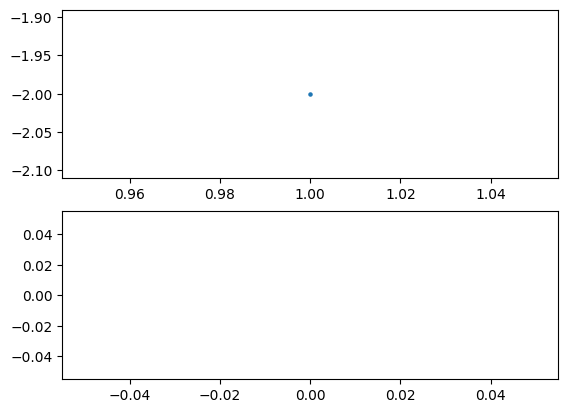

In [8]:
#导入matplotlib函数库
import matplotlib.pyplot as plt

#定义两个曲线的坐标数组
score_x, score_y = [], []
loss_x, loss_y = [], []

#读取日志文件
log_file = open(myrobot.log_file_name, 'r')
for line in log_file.readlines():
    var_name, var_value, round_num = line.split(' ')
    #存储比分曲线数据
    if var_name == 'score':
        score_x.append(int(round_num))
        score_y.append(int(var_value))
    #存储loss曲线数据
    if var_name == 'loss':
        loss_x.append(int(round_num))
        loss_y.append(float(var_value))

#分两个子图以散点图的方式绘制比分曲线和loss值曲线
fig, axes = plt.subplots(2,1)
axes[0].scatter(np.array(score_x),np.array(score_y),s=5)
axes[1].scatter(np.array(loss_x),np.array(loss_y),s=5)

plt.show()

## 小结

本课介绍了DQN算法的原理及各种衍生算法的改进，并给出了如何在数字冰壶比赛中应用DQN算法的范例代码。

DQN算法是典型的离线算法，而且基于的是价值网络来估算Q函数的值。这类算法的特点是可以用线上的智能体采集的数据不断回放，从而提高算法的表现。在实际应用中，DQN算法往往有比较高的数据利用率，相对于各种在线算法能够有效地减少采样的次数。因此，它们是比较常用的一类算法，在实践中也得到了广泛的应用。

<b>注意：由于强化学习模型需要长期持续训练才能有好的效果，而我们的Jupyter在线课程平台很难保证长期持续的网络连接，所以本教程仅用于讲解并演示强化学习模型的训练和部署，实际的模型训练建议下载单机版数字冰壶平台在本机进行。详见本教程的第八课《08.并行DQN以及并行PPO》。</b>